In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


### Загружаем данные

In [2]:
item = "taxi"  # Выбрать из поля Item для вашего датасета
package = "modeldata"  # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package, cache=True).data
df.head()

,tip,distance,company,local,dow,month,hour
0,yes,17.19,Chicago Independents,no,Thu,Feb,16
1,yes,0.88,City Service,yes,Thu,Mar,8
2,yes,18.11,other,no,Mon,Feb,18
3,yes,20.70,Chicago Independents,no,Mon,Apr,8
4,yes,12.23,Chicago Independents,no,Sun,Mar,21


### Изучите внимательно ваш датасет и смысл переменных, которые в нем содержатся. Проведите очистку данных от пропусков, выбросов и некорректных значений любым выбранным способом. Постарайтесь обосновать этот способ.

Вывод общей информации о датафрейме, типы данных, количество, количество не пропущенных значений по каждому из столбцов.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tip       10000 non-null  object 
 1   distance  10000 non-null  float64
 2   company   10000 non-null  object 
 3   local     10000 non-null  object 
 4   dow       10000 non-null  object 
 5   month     10000 non-null  object 
 6   hour      10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


Вывод уникальных значений для поиска аномальных (например: '-', 'not').

In [4]:
df_filtered = df.drop("distance", axis=1)
unique_values = {col: df_filtered[col].unique().tolist() for col in df_filtered.columns}

# Находим максимальную длину списка уникальных значений
max_len = max(len(values) for values in unique_values.values())

# Создаём DataFrame, где значения дополняются None до максимальной длины
unique_df = pd.DataFrame(
    {col: unique_values[col] + [None] * (max_len - len(unique_values[col])) for col in df_filtered.columns}
)
unique_df = unique_df.fillna("")
unique_df

,tip,company,local,dow,month,hour
0,yes,Chicago Independents,no,Thu,Feb,16
1,no,City Service,yes,Mon,Mar,8
2,,other,,Sun,Apr,18
3,,Sun Taxi,,Sat,Jan,21
4,,Flash Cab,,Fri,,23
5,,Taxicab Insurance Agency Llc,,Tue,,12
6,,Taxi Affiliation Services,,Wed,,6
7,,,,,,14
8,,,,,,11
9,,,,,,19


Необходимо узнать есть ли дисбаланс классов, вывод соотношения данных по target переменной - `tip`

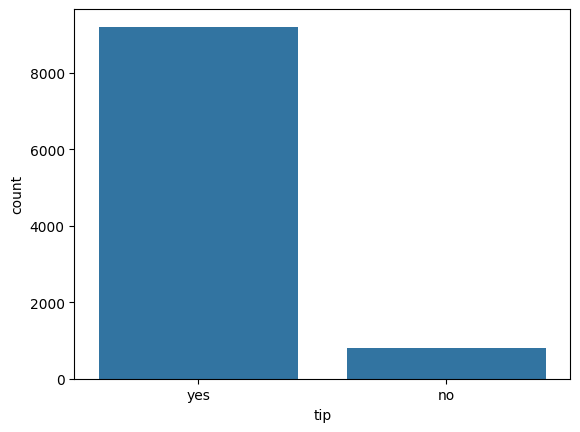

In [5]:
sns.countplot(df, x="tip")
plt.show()

Датасет хранит информацию о поездках в Чикаго в 2022. Данные собирались для решения задачи предсказания оставит ли пассажир чаевые или нет.

**Набор данных не имеет пропущенных значений**, но наблюдается весьма сильный дисбаланс классов.

Столбцы:
* tip - категориальная бинарная переменная. Показывает оставил ли пассажир чаевые.
* distance - значение с плавающей точкой. Дистанция поездки в милях.
* company - категориальная переменная. Компании поставщики услуги. Компании которые редко встречались были помечены как other.
* local - категориальная бинарная переменная. Находятся ли начальная и конечная точки в одном населенном пункте.
* dow - категориальная переменная. День недели в который началась поездка.
* month - категориальная переменная. Месяц в который началась поездка.
* hour- категориальная переменная. Час начала поездки.

Переменную month я бы удалил из датасета т. к собраны данные всего за 4 месяца 2 из которых не полные.

In [6]:
df_clear = df.drop("month", axis=1)

### Исходя из смысла представленного датасета приведите наиболее подходящие описательные представления как самих переменных по отдельности, так и их возможной взаимосвязи. Проведите разведочный анализ данных для выбранных переменных. Постройте графики, которые бы давали представление о связи выбранных переменных

Есть смысл посмотреть на описательные статистики по расстоянию.

In [7]:
df["distance"].describe()

count    10000.000000
mean         6.224144
std          7.381397
min          0.000000
25%          0.940000
50%          1.780000
75%         15.562500
max         42.300000
Name: distance, dtype: float64

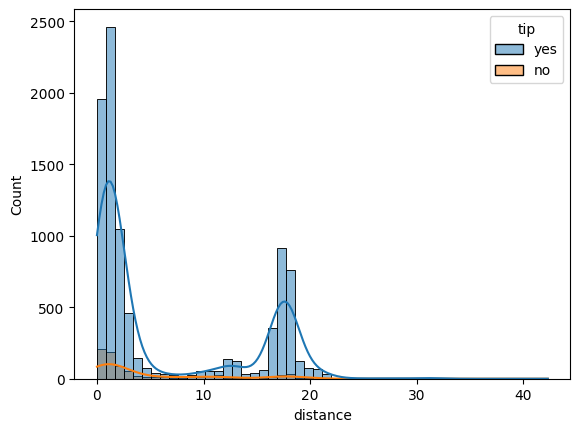

In [8]:
sns.histplot(df, x="distance", hue="tip", bins=50, kde=True)
plt.show()

Медианное значение весьма короткое, 1.78 мили, но среднее сильно скошено из-за длинных поездок. На графике видно что распределение бимодально первая мода сконцентрирована около коротких поездок, а вторая более длительных. **Можно предположить что чаевые реже дают в длинных поездках.** Стоит отметить довольно таки большое количество выбросов.

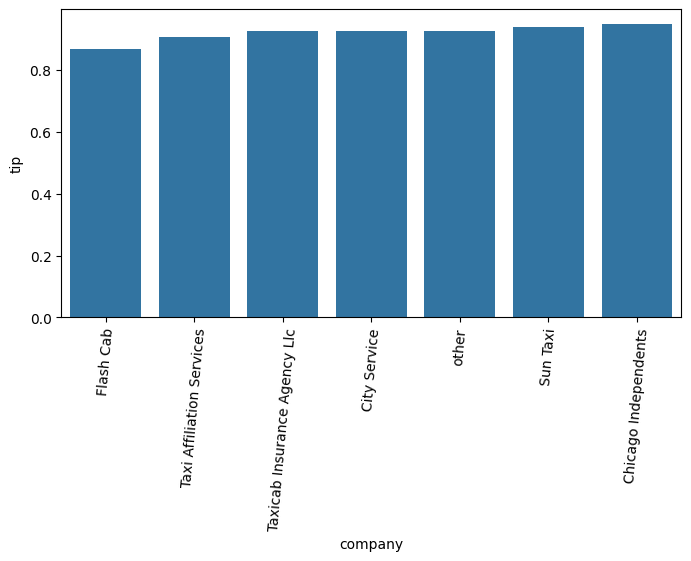

In [9]:
tip_rates = df.copy()
tip_rates["tip"] = np.int64(tip_rates["tip"] == "yes")
tip_rates = tip_rates.groupby("company")["tip"].mean().reset_index()
tip_rates = tip_rates.sort_values(by="tip")
plt.figure(figsize=(8, 4))
plt.xticks(rotation=85)
sns.barplot(tip_rates, x="company", y="tip")
plt.show()

Можно предположить что в зависимости от компании есть небольшая разница в соотношении оставленных чаевых.

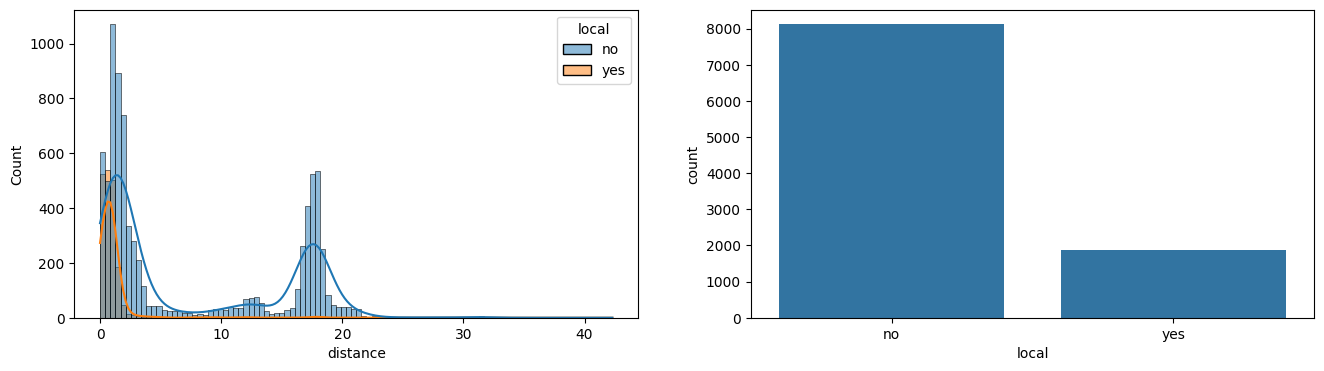

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(df, x="distance", hue="local", bins=100, kde=True, ax=axes[0])
sns.countplot(df, x="local", ax=axes[1])
plt.show()

Абсолютное большинство поездок за пределы населенного пункта.

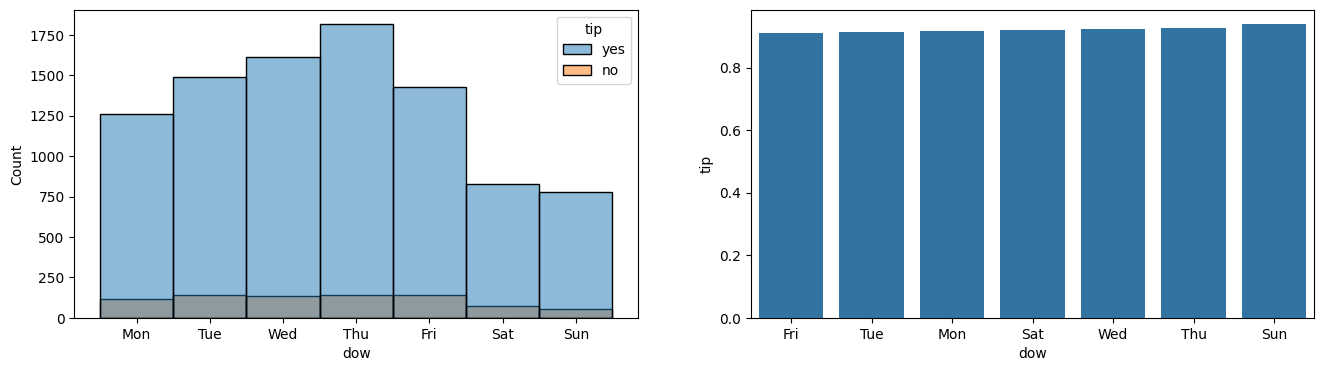

In [11]:
tip_rates = df.copy()
tip_rates["tip"] = np.int64(tip_rates["tip"] == "yes")
tip_rates = tip_rates.groupby("dow")["tip"].mean().reset_index()
tip_rates = tip_rates.sort_values(by="tip")

df_cpy = df.copy()
dow_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df_cpy["dow"] = pd.Categorical(df_cpy["dow"], categories=dow_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(df_cpy, x="dow", hue="tip", ax=axes[0])
sns.barplot(tip_rates, x="dow", y="tip", ax=axes[1])
plt.show()

Количество поездок постепенно растет к четвергу, резко падает в пятницу и еще сильнее в субботу. Наименьшее количество поездок в выходные. **Можно предположить что соотношение чаевых от дня недели почти не зависит.**

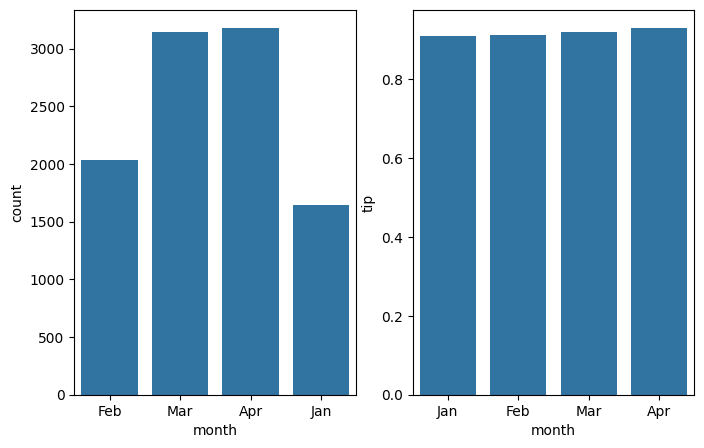

In [12]:
tip_rates = df.copy()
tip_rates["tip"] = np.int64(tip_rates["tip"] == "yes")
tip_rates = tip_rates.groupby("month")["tip"].mean().reset_index()
tip_rates = tip_rates.sort_values(by="tip")

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
sns.countplot(df, x="month", ax=axes[0])
sns.barplot(tip_rates, x="month", y="tip", ax=axes[1])
plt.show()

Исходя из графиков выше, количество поездок в феврале и июне наименьшее. Скорее всего это связано с началом и концом сбора данных. **Можно предположить что соотношение чаевых не зависит от месяца (слишком мало данных чтобы утверждать это).** В марте и апреле почти одинаковое количество поездок

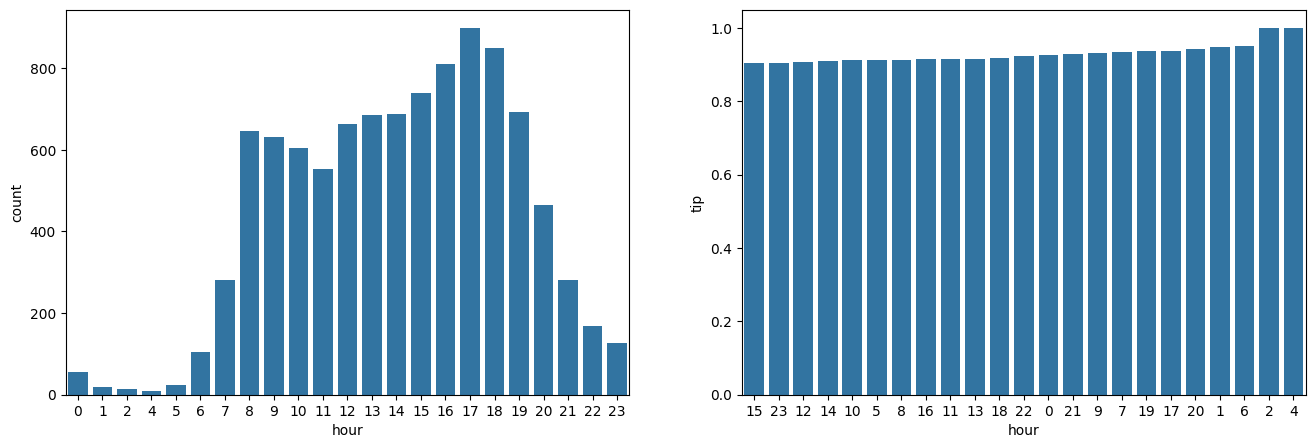

In [13]:
tip_rates = df.copy()
tip_rates["tip"] = np.int64(tip_rates["tip"] == "yes")
tip_rates = tip_rates.groupby("hour")["tip"].mean().reset_index()
tip_rates = tip_rates.sort_values(by="tip")
tip_rates["hour"] = pd.Categorical(tip_rates["hour"], categories=tip_rates["hour"], ordered=True)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(df, x="hour", ax=axes[0])
sns.barplot(tip_rates, x="hour", y="tip", ax=axes[1])
plt.show()

Больше всего поездок утром в 8-9 часов и вечером в 17-18 часов, скорее всего люди едут на работу и с работы. Также можно предположить что люди оставляют чаевые чаще по ночам с 1 до 6.

С помощью логистической регрессии можно в целом посмотреть на взаимосвязь между фичами и таргет переменной.

In [14]:
# Скоринг функция для обучения модели, для решения текущей задачи важен класс False (когда клиент не платит чаевые).
f1_scorer = make_scorer(f1_score, pos_label=False)
preprocessor = ColumnTransformer(
    transformers=(
        ("categorical-one-hot", OneHotEncoder(), ["company", "hour", "dow"]),
        ("categorical-binary", FunctionTransformer(lambda x: x == "yes"), ["local"]),
        ("numeric", StandardScaler(), ["distance"]),
    ),
    remainder="drop",
)
pipeline = Pipeline((("preprocessor", preprocessor), ("model", LogisticRegression(random_state=42))))
grid_params = {
    "model__C": [0.1, 1, 10],  # параметр регуляризации
    "model__penalty": ["l2", "l1"],  # тип регуляризации
    "model__solver": ["liblinear"],
}
grid = GridSearchCV(pipeline, grid_params, n_jobs=-1)
grid.fit(df_clear.drop("tip", axis=1), df_clear["tip"] == "yes")

GridSearchCV(estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('categorical-one-hot',
                                                                         OneHotEncoder(),
                                                                         ['company',
                                                                          'hour',
                                                                          'dow']),
                                                                        ('categorical-binary',
                                                                         FunctionTransformer(func=<function <lambda> at 0x00000152BB27FE20>),
                                                                         ['local']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['distance'])))),
                                       ('model',
                                        LogisticRegression(random_state=42)))),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'],
                         'model__solver': ['liblinear']})

In [15]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014696,0.002518,0.003544,0.001282,0.1,l2,liblinear,"{'model__C': 0.1, 'model__penalty': 'l2', 'mod...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1
1,0.014049,0.001502,0.003357,0.000936,0.1,l1,liblinear,"{'model__C': 0.1, 'model__penalty': 'l1', 'mod...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1
2,0.012224,0.001771,0.003819,0.001179,1.0,l2,liblinear,"{'model__C': 1, 'model__penalty': 'l2', 'model...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1
3,0.031735,0.000808,0.004018,0.000012,1.0,l1,liblinear,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1
4,0.013333,0.000756,0.002809,0.000751,10.0,l2,liblinear,"{'model__C': 10, 'model__penalty': 'l2', 'mode...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1
5,0.184549,0.016698,0.001961,0.002420,10.0,l1,liblinear,"{'model__C': 10, 'model__penalty': 'l1', 'mode...",0.921,0.921,0.921,0.921,0.9205,0.9209,0.0002,1


In [16]:
# FunctionTransformer не поддерживает метод get_feature_names_out, поэтому собираются название фичей так

feature_names = []
for name, trans, cols in grid.best_estimator_["preprocessor"].transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

pd.DataFrame(
    data=grid.best_estimator_["model"].coef_,
    columns=feature_names,
).T

,0
company_Chicago Independents,0.579514
company_City Service,0.298064
company_Flash Cab,-0.223372
company_Sun Taxi,0.483000
company_Taxi Affiliation Services,0.123466
company_Taxicab Insurance Agency Llc,0.287165
company_other,0.350195
hour_0,0.019320
hour_1,0.078056
hour_2,0.109521


Из полученных данных можно предположить:
* есть положительная корреляция между расстоянием и вероятностью частотой оплаты чаевых, при этом в пределах населенного пункта чаевые дают реже.
* в воскресенье чаевые платят чаще.
* в зависимости от компании чаевые могут платить чаще или реже
* от часа поездки также есть некоторая зависимость

### На основе проведенных наблюдений о взаимосвязи между переменными сформулируйте задачу классификации или регрессии, которая может иметь практическую ценность.

На основе данных поставлена следующая задача - попытаться предсказать заплатит ли пассажир чаевые. Это задача классификации.

### Разделите датасет на обучающую (60%) и тестовую (40%) выборки. Далее тестовую выборку разделите пополам (20% и 20%)

In [17]:
df_clear["tip"] = df_clear["tip"] == "yes"

In [18]:
train_x, test_x, train_y, test_y = train_test_split(
    df_clear.drop("tip", axis=1),
    df_clear["tip"],
    test_size=0.4,
    random_state=42,
    stratify=df["tip"],
)

In [19]:
test_x, observe_x, test_y, _ = train_test_split(test_x, test_y, test_size=0.5, random_state=42, stratify=test_y)

### Обучите 3 различные модели, проведите оценку их качества на первой половине тестовой выборки

Необходимо сделать препроцессор для предобработки всех данных

In [20]:
preprocessor = ColumnTransformer(
    transformers=(
        ("categorical-one-hot", OneHotEncoder(), ["company", "hour", "dow"]),
        ("categorical-binary", FunctionTransformer(lambda x: x == "yes"), ["local"]),
        ("numeric", StandardScaler(), ["distance"]),
    ),
    remainder="drop",
)

Скоринг функция для обучения модели, для решения текущей задачи важен класс False (когда клиент не платит чаевые).

In [21]:
f1_scorer = make_scorer(f1_score, pos_label=False)

#### Первая модель на основе Bootstrap aggregation.

In [22]:
pipeline = Pipeline((("preprocessor", preprocessor), ("model", BaggingClassifier(random_state=42, n_jobs=-1))))

param_grid = [
    {
        "model": [
            BaggingClassifier(random_state=42, n_jobs=-1, estimator=LogisticRegression(n_jobs=-1, random_state=42))
        ],
        "model__n_estimators": range(10, 110, 10),
        "model__estimator__C": [0.1, 1, 10],  # параметр регуляризации
        "model__estimator__penalty": ["l2", "l1"],  # тип регуляризации
        "model__estimator__solver": ["liblinear"],
    },
    {
        "model": [BaggingClassifier(random_state=42, n_jobs=-1, estimator=KNeighborsClassifier(n_jobs=-1))],
        "model__n_estimators": range(10, 110, 10),
        "model__estimator__n_neighbors": [3, 5, 7, 9, 11],
    },
    {
        "model": [BaggingClassifier(random_state=42, n_jobs=-1, estimator=SVC(random_state=42))],
        "model__n_estimators": range(10, 110, 10),
        "model__estimator__kernel": ["linear", "rbf"],
        "model__estimator__C": [0.1, 1, 10, 100],
        "model__estimator__gamma": [0.001, 0.01, 0.1, 1],
    },
    {
        "model": [BaggingClassifier(random_state=42, n_jobs=-1, estimator=DecisionTreeClassifier(random_state=42))],
        "model__n_estimators": range(10, 110, 10),
        "model__estimator__max_depth": [1, 2, 3, 4],
    },
]
grid1 = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, n_jobs=-1)
grid1.fit(train_x, train_y)

GridSearchCV(estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('categorical-one-hot',
                                                                         OneHotEncoder(),
                                                                         ['company',
                                                                          'hour',
                                                                          'dow']),
                                                                        ('categorical-binary',
                                                                         FunctionTransformer(func=<function <lambda> at 0x0000015296E587C0>),
                                                                         ['local']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['distance'])))),
                                       ('model',
                                        BaggingClassifier(n_jobs=-1,
                                                          random_state=42)))...
                          'model__estimator__gamma': [0.001, 0.01, 0.1, 1],
                          'model__estimator__kernel': ['linear', 'rbf'],
                          'model__n_estimators': range(10, 110, 10)},
                         {'model': [BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                                      n_jobs=-1,
                                                      random_state=42)],
                          'model__estimator__max_depth': [1, 2, 3, 4],
                          'model__n_estimators': range(10, 110, 10)}],
             scoring=make_scorer(f1_score, response_method='predict', pos_label=False))

10 лучших комбинаций параметров для полученной модели

In [23]:
results = pd.DataFrame(grid1.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__estimator__C,param_model__estimator__penalty,param_model__estimator__solver,param_model__n_estimators,param_model__estimator__n_neighbors,...,param_model__estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
440,0.134989,0.019582,0.049949,0.013204,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,10,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
441,0.136621,0.007677,0.044307,0.027376,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,20,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
442,0.111090,0.020829,0.059881,0.002476,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,30,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
443,0.122955,0.016403,0.047946,0.012995,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,40,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
444,0.118612,0.009233,0.051276,0.017770,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,50,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
445,0.108295,0.014659,0.039149,0.013469,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,60,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
446,0.123593,0.016237,0.052363,0.010260,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,70,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
447,0.145727,0.019974,0.048762,0.012778,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,80,NaN,...,2.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
432,0.113677,0.016437,0.036027,0.014749,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,30,NaN,...,1.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1
433,0.142194,0.030655,0.043971,0.032866,BaggingClassifier(estimator=DecisionTreeClassi...,NaN,NaN,NaN,40,NaN,...,1.0,{'model': BaggingClassifier(estimator=Decision...,0.105263,0.158273,0.088235,0.133333,0.178082,0.132637,0.032996,1


Лучшие метрики получились на основе решающих деревьев, при этом увеличение их количества не помогало, также с увеличением глубины качество ухудшалось.

              precision    recall  f1-score   support

       False       0.18      0.08      0.11       158
        True       0.92      0.97      0.95      1842

    accuracy                           0.90      2000
   macro avg       0.55      0.52      0.53      2000
weighted avg       0.87      0.90      0.88      2000



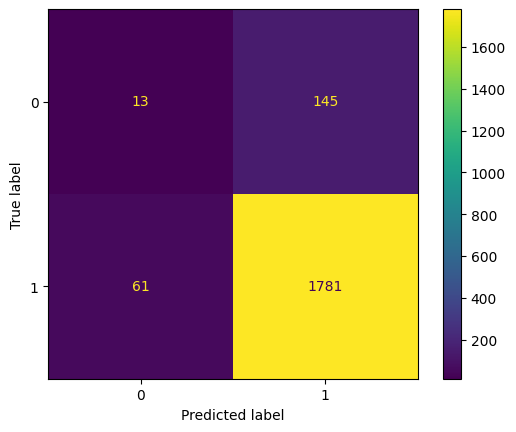

In [24]:
predicted = grid1.predict(test_x)
print(classification_report(test_y, predicted))
ConfusionMatrixDisplay(confusion_matrix(test_y, predicted)).plot()
plt.show()

Получилась модель с очень плохими метриками, слишком много ложно положительных результатов, всего удается правильно определить тех кто не заплатит в 8% случаев (recall для этого класса составляет всего 0.08). При этом есть 61 ложно отрицательных срабатываний.

#### Вторая модель на основе Boosting

In [25]:
pipeline = Pipeline((("preprocessor", preprocessor), ("model", GradientBoostingClassifier(random_state=42))))

param_grid = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 3],
    "model__subsample": [0.7, 1.0],
    "model__max_features": ["sqrt", "log2"],
}

grid2 = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, n_jobs=-1)
grid2.fit(train_x, train_y)

GridSearchCV(estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('categorical-one-hot',
                                                                         OneHotEncoder(),
                                                                         ['company',
                                                                          'hour',
                                                                          'dow']),
                                                                        ('categorical-binary',
                                                                         FunctionTransformer(func=<function <lambda> at 0x0000015296E587C0>),
                                                                         ['local']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['distance'])))),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42)))),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 3],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 300, 500],
                         'model__subsample': [0.7, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=False))

In [26]:
results = pd.DataFrame(grid2.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
429,0.734120,0.019158,0.016298,0.001093,0.10,7,log2,3,5,300,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.125000,0.131148,0.066667,0.079365,0.120690,0.104574,0.026289,1
423,0.739023,0.014100,0.018168,0.004828,0.10,7,log2,3,2,300,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.125000,0.131148,0.066667,0.079365,0.120690,0.104574,0.026289,1
243,0.958004,0.015058,0.016370,0.000823,0.05,7,sqrt,1,2,300,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.092593,0.111111,0.088496,0.139130,0.090909,0.104448,0.019108,3
431,1.224246,0.027469,0.023645,0.004188,0.10,7,log2,3,5,500,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.100840,0.122137,0.062992,0.128571,0.100000,0.102908,0.022954,4
425,1.238375,0.026802,0.026628,0.001229,0.10,7,log2,3,2,500,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.100840,0.122137,0.062992,0.128571,0.100000,0.102908,0.022954,4
398,0.770500,0.017877,0.016760,0.000926,0.10,7,sqrt,3,2,300,0.7,"{'model__learning_rate': 0.1, 'model__max_dept...",0.112150,0.114754,0.052174,0.096774,0.136752,0.102521,0.028220,6
404,0.764500,0.011105,0.016655,0.000757,0.10,7,sqrt,3,5,300,0.7,"{'model__learning_rate': 0.1, 'model__max_dept...",0.112150,0.114754,0.052174,0.096774,0.136752,0.102521,0.028220,6
387,0.995439,0.010208,0.017051,0.000893,0.10,7,sqrt,1,2,300,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.081967,0.064000,0.078740,0.151515,0.129032,0.101051,0.033360,8
287,1.228176,0.020566,0.026722,0.001581,0.05,7,log2,3,5,500,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.132075,0.136752,0.054545,0.069565,0.109091,0.100406,0.033027,9
281,1.218508,0.034098,0.026778,0.001140,0.05,7,log2,3,2,500,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.132075,0.136752,0.054545,0.069565,0.109091,0.100406,0.033027,9


              precision    recall  f1-score   support

       False       0.23      0.04      0.07       158
        True       0.92      0.99      0.95      1842

    accuracy                           0.91      2000
   macro avg       0.57      0.52      0.51      2000
weighted avg       0.87      0.91      0.88      2000



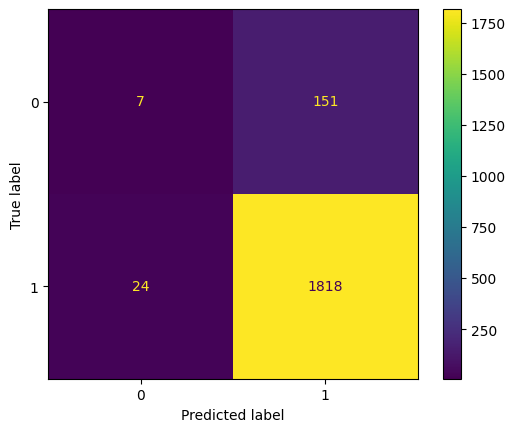

In [27]:
predicted = grid2.predict(test_x)
print(classification_report(test_y, predicted))
ConfusionMatrixDisplay(confusion_matrix(test_y, predicted)).plot()
plt.show()

Бустинг также не дал хороших результатов. Получилась модель с очень плохими метриками, слишком много ложно положительных результатов, всего удается правильно определить тех кто не заплатит в 4% случаев (recall для этого класса составляет всего 0.04). Также есть ложно отрицательные срабатывания - 24.

#### Третью модель можно попробовать получить на основе случайного леса

In [28]:
pipeline = Pipeline((("preprocessor", preprocessor), ("model", RandomForestClassifier(random_state=42, n_jobs=-1))))

param_grid = {
    "model__n_estimators": [10, 50, 100, 200],  # количество деревьев
    "model__min_samples_split": [2, 5, 10],  # минимальное число объектов для разбиения
    "model__max_depth": [1, 2, 3],  # максимальная глубина
    "model__min_samples_leaf": [1, 2, 4],  # минимальное число объектов в листе
    "model__max_features": ["sqrt", "log2", None],  # сколько признаков использовать при поиске лучшего разделения
    "model__bootstrap": [True, False],  # использовать бутстрэповую выборку или всю обучающую
    "model__criterion": ["gini", "entropy", "log_loss"],  # функция оценки качества сплита
    "model__class_weight": [None, "balanced"],  # автоматическое взвешивание классов
}

grid3 = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, n_jobs=-1)
grid3.fit(train_x, train_y)

GridSearchCV(estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('categorical-one-hot',
                                                                         OneHotEncoder(),
                                                                         ['company',
                                                                          'hour',
                                                                          'dow']),
                                                                        ('categorical-binary',
                                                                         FunctionTransformer(func=<function <lambda> at 0x0000015296E587C0>),
                                                                         ['local']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['distance'])))),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=...
             param_grid={'model__bootstrap': [True, False],
                         'model__class_weight': [None, 'balanced'],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [1, 2, 3],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 50, 100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=False))

In [29]:
results = pd.DataFrame(grid3.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__class_weight,param_model__criterion,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1158,0.157248,0.026584,0.037458,0.017806,True,balanced,gini,2,None,1,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1166,0.152138,0.028121,0.049588,0.007085,True,balanced,gini,2,None,2,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1174,0.153032,0.028801,0.033697,0.011432,True,balanced,gini,2,None,2,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1162,0.160910,0.031929,0.030893,0.017434,True,balanced,gini,2,None,1,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1178,0.170053,0.017757,0.038365,0.008812,True,balanced,gini,2,None,4,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1170,0.175153,0.043284,0.036320,0.008741,True,balanced,gini,2,None,2,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1186,0.173371,0.061667,0.036387,0.017453,True,balanced,gini,2,None,4,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1182,0.177435,0.036947,0.042946,0.022386,True,balanced,gini,2,None,4,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1154,0.137176,0.016555,0.035527,0.019988,True,balanced,gini,2,None,1,...,100,"{'model__bootstrap': True, 'model__class_weigh...",0.229508,0.217228,0.192857,0.2,0.209231,0.209765,0.012861,1
1167,0.278051,0.032984,0.059594,0.016787,True,balanced,gini,2,None,2,...,200,"{'model__bootstrap': True, 'model__class_weigh...",0.224900,0.208494,0.192857,0.2,0.221402,0.209531,0.012223,10


              precision    recall  f1-score   support

       False       0.12      0.23      0.15       158
        True       0.93      0.85      0.88      1842

    accuracy                           0.80      2000
   macro avg       0.52      0.54      0.52      2000
weighted avg       0.86      0.80      0.83      2000



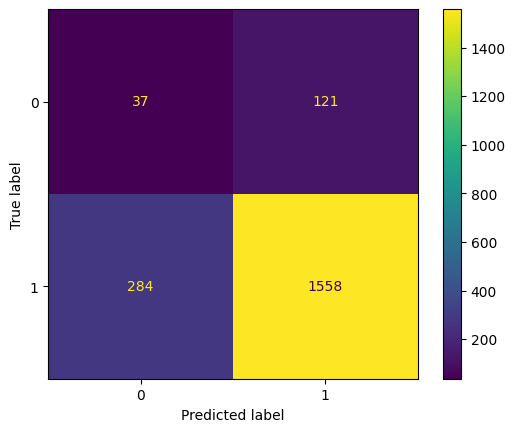

In [30]:
predicted = grid3.predict(test_x)
print(classification_report(test_y, predicted))
ConfusionMatrixDisplay(confusion_matrix(test_y, predicted)).plot()
plt.show()

Случайный лес также не дал хороших результатов. Получилась модель с очень плохими метриками, слишком много ложно положительных результатов, всего удается правильно определить тех кто не заплатит в 15% случаев (recall для этого класса составляет всего 0.15). Помимо этого появилось огромное количество ложно отрицательных срабатываний - 284 и f1 для этого класса упал до 0.88

### Выберите ту модель и набор переменных, которые по вашему мнению дают наиболее удовлетворительное качество.

Ни одна из моделей не может удовлетворить требованиям - определить даст ли клиент чаевые на основе входных данных невозможно. Необходимо учитывать больше данных. 1 модель обладает наилучшими качествами для решения данной задачи т. к имеет сбалансированные показатели это подтверждает macro avg f1 score.

### На основе второй половины тестовой выборки сделайте предсказание целевой переменной. На основе предсказаний сделайте рекомендации для потенциальных пользователей вашего анализа

In [31]:
observe_x["tip"] = grid1.predict(observe_x)
observe_x

,distance,company,local,dow,hour,tip
6104,1.95,Flash Cab,no,Wed,17,True
3618,1.31,Sun Taxi,no,Sun,14,True
1181,21.16,other,no,Fri,9,True
4654,1.36,other,yes,Fri,19,True
3969,0.80,Taxi Affiliation Services,no,Sat,20,True
...,...,...,...,...,...,...
9011,0.88,City Service,yes,Thu,18,True
2736,3.57,Sun Taxi,no,Sat,9,True
9718,0.74,Sun Taxi,yes,Fri,17,True
228,17.40,other,no,Thu,10,True


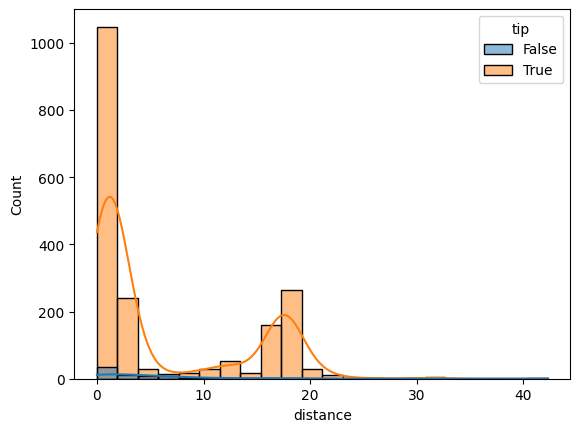

In [32]:
sns.histplot(observe_x, x="distance", hue="tip", kde=True)
plt.show()

На более длинных дистанциях пассажиры чаще дают чаевые, возможно водителям стоит сконцентрироваться на таких заказах.

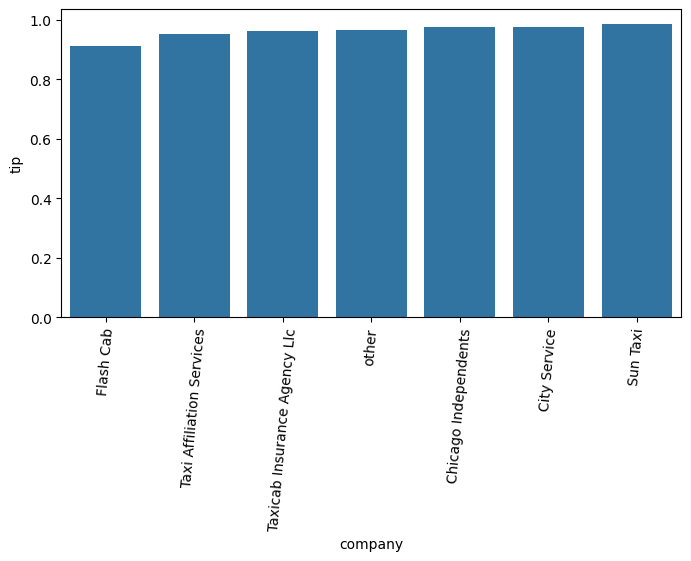

In [33]:
tip_rates = observe_x.copy()
tip_rates = tip_rates.groupby("company")["tip"].mean().reset_index()
tip_rates = tip_rates.sort_values(by="tip")
plt.figure(figsize=(8, 4))
plt.xticks(rotation=85)
sns.barplot(tip_rates, x="company", y="tip")
plt.show()

Устроиться в более прибыльные компании, например Chicago Independents.

Стоит увеличить количество собираемых данных, для улучшения задачи классификации. Можно попробовать собирать статистику по каждому пользователю и использовать еще и исторические данные.

С помощью предсказания можно делать поправку и повышать цену на среднее количество чаевых типичных для заданной поездки, затем добавлять их к вознаграждению водителя.